# Application of ML-based algorithm on The UNSW_NNB15 Datasets


## Library


In [1]:
#%pip install scikit-learn pandas numpy prettyprint cupy tqdm matplotlib colorama

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from typing import Literal
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neighbors import KNeighborsClassifier
from gc import collect
from time import sleep
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cupy as cp
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Style


## Loading the data set


In [3]:
TRAIN_DATASET = 'UNSW_NB15_training-set.csv'
TEST_DATASET = 'UNSW_NB15_testing-set.csv'

In [4]:
# Loading the csv data in a DataFrame
df_train = pd.read_csv(TRAIN_DATASET)
df_test = pd.read_csv(TEST_DATASET)

In [5]:
df_train.head(5)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [6]:
def print_dataframe_shape(df:pd.DataFrame,name):print(f"The shape of {name} is: {df.shape}")

In [7]:
print_dataframe_shape(df_train,'Training Set')
print_dataframe_shape(df_test,'Testing Set')

The shape of Training Set is: (175341, 45)
The shape of Testing Set is: (82332, 45)


In [8]:
# Creating a type of all the Features
Features = Literal['dur',
 'proto',
 'service',
 'state',
 'spkts',
 'dpkts',
 'sbytes',
 'dbytes',
 'rate',
 'sttl',
 'dttl',
 'sload',
 'dload',
 'sloss',
 'dloss',
 'sinpkt',
 'dinpkt',
 'sjit',
 'djit',
 'swin',
 'stcpb',
 'dtcpb',
 'dwin',
 'tcprtt',
 'synack',
 'ackdat',
 'smean',
 'dmean',
 'trans_depth',
 'response_body_len',
 'ct_srv_src',
 'ct_state_ttl',
 'ct_dst_ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'is_ftp_login',
 'ct_ftp_cmd',
 'ct_flw_http_mthd',
 'ct_src_ltm',
 'ct_srv_dst',
 'is_sm_ips_ports',
 'label']

### Understanding the data


In [9]:
y_label = 'label' # setting the label
features_list = df_train.columns.tolist()

In [10]:
def separate(df:pd.DataFrame,):
    features = features_list.copy()
    features.remove(y_label)
    return df.drop(y_label,axis=1),df[y_label] # separate a DataFrame of the features and the label

## Preprocessing the Data


### Cleaning the Data


#### Helper Function

In [11]:
def standardize(df,column:Features): # Standardizing the values of a features that has continuous values
    col_values = df[column].values

    mean = np.mean(col_values)
    std = np.std(col_values)
    col_values = col_values-mean
    col_values= col_values/std
    return pd.Series(col_values, name=column)


def min_max_scaling(df, column:Features): # MinMax scaling the values of a features that has continuous values
    col_values = df[column].values
    min_value = np.min(col_values)
    max_value = np.max(col_values)
    scaled_values = (col_values - min_value) / (max_value - min_value)
    return pd.Series(scaled_values, name=column)

def state_to_mask(state_vector: np.ndarray): # Creating a Mask for feature that has equally important state
    unique_val = np.unique(state_vector)
    size = len(unique_val)
    return { unique_val[mask]:mask for mask in range(size)}

def one_hot_encoding(state_mask:dict[int,str]): # Creating a function that returns a one hot encoding from a Mask
    def wrapper(mask: str):
        v = np.zeros((1, len(state_mask)))
        mask = state_mask[mask]
        v[0][mask] = 1
        return v
    return wrapper

def one_hot_vector_distance(v1: np.ndarray, v2: np.ndarray): # Compute the distance between two one hot encoding vector
    if v1.shape != v2.shape:
        raise
    if np.array_equal(v1, v2):
        return 0
    return 1

def str_encoder(df:pd.DataFrame,column:Features): # Set string to a equally important state
    label_encoder = LabelEncoder()
    df[column] = label_encoder.fit_transform(df[column])

In [12]:

def remove_uncessaryFeature(df: pd.DataFrame, features: list = []): # Function to remove features 
    try:
        return df.drop(features, axis=1)
    except KeyError :
        return df

#### Cleaning Function ...

In [13]:
features_to_normalize=['dur','spkts','stcpb','dtcpb','dpkts','dbytes','sbytes',
                       'rate',
    'sload','dload','sloss','dloss','sinpkt','dinpkt','sjit','djit','tcprtt','synack','smean','dmean','response_body_len',]
features_to_ohe=['proto','service','state','is_ftp_login','ct_ftp_cmd','ct_flw_http_mthd','ct_state_ttl','is_sm_ips_ports']
initial_features_to_remove = ['id','attack_cat']

text_featuresType = ['proto','service','state']

def preprocess_final(df:pd.DataFrame, normalize: Literal['min_max_scaling','standardize']=standardize,features_to_remove:list=[]):

    ftr = set(features_to_remove)
    df =remove_uncessaryFeature(df,[*initial_features_to_remove,*features_to_remove]) # Removing uncessary feature

    # Set values to a equally important state
    for feature in set(features_to_ohe).difference(ftr).union(text_featuresType):
        str_encoder(df,feature)

    #Normalize continuous feature
    for feature in set(features_to_normalize).difference(ftr):
        df[feature] = normalize(df,feature)

    return df


In [14]:

def preprocess_partial(df:pd.DataFrame):

    # Removing uncessary feature
    df =remove_uncessaryFeature(df,['label',*initial_features_to_remove])

    # Set values to a equally important state
    for feature in text_featuresType:
        str_encoder(df,feature)

    #Normalize continuous feature
    for feature in features_to_normalize:
        df[feature] = standardize(df,feature)

    return df

## Feature Selection


##### Looking for the features that has highest impact


In [15]:
df_feature_analysis= preprocess_partial(df_train) # Creating a preprocessed DataFrame to compute some Feature Engineering

##### Correlation Matrix


In [16]:
# Find the highest correlation of a feature
def find_highest_correlation(corr_matrix:pd.DataFrame, target_feature:str):
    target_corr = corr_matrix[target_feature].drop(target_feature)
    highest_corr_feature = target_corr.idxmax()
    highest_corr_value = target_corr[highest_corr_feature]

    return highest_corr_feature, highest_corr_value


In [17]:
corr_matrix = df_feature_analysis.corr().apply(abs) # Get the correlation matrix with absolute values
corr_matrix

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
dur,1.000000,0.124502,0.008234,0.103443,0.254559,0.181182,0.199731,0.144134,0.120966,0.012196,...,0.086300,0.094091,0.093923,0.101760,0.020641,0.020641,0.024743,0.080871,0.115336,0.035370
proto,0.124502,1.000000,0.170032,0.172441,0.013469,0.026439,0.005920,0.015812,0.013924,0.049944,...,0.191101,0.174965,0.165796,0.175708,0.018003,0.018003,0.028809,0.168121,0.198594,0.585941
service,0.008234,0.170032,1.000000,0.144978,0.114403,0.077338,0.105188,0.035492,0.141709,0.295302,...,0.047685,0.038347,0.051106,0.006774,0.071051,0.071051,0.266206,0.028599,0.048011,0.088847
state,0.103443,0.172441,0.144978,1.000000,0.078701,0.098268,0.049300,0.059759,0.432307,0.584697,...,0.328748,0.372309,0.408662,0.429906,0.051970,0.051970,0.078856,0.323019,0.387446,0.094198
spkts,0.254559,0.013469,0.114403,0.078701,1.000000,0.390067,0.963791,0.206609,0.076358,0.102723,...,0.060194,0.068373,0.072484,0.077553,0.009951,0.009951,0.006084,0.061584,0.069598,0.017770
dpkts,0.181182,0.026439,0.077338,0.098268,0.390067,1.000000,0.188476,0.971907,0.098202,0.192580,...,0.071909,0.086695,0.094267,0.094085,0.013491,0.013491,0.047974,0.075190,0.078342,0.021765
sbytes,0.199731,0.005920,0.105188,0.049300,0.963791,0.188476,1.000000,0.009926,0.028468,0.020860,...,0.026661,0.026490,0.027281,0.032061,0.004515,0.004515,0.002185,0.027479,0.034553,0.006367
dbytes,0.144134,0.015812,0.035492,0.059759,0.206609,0.971907,0.009926,1.000000,0.059475,0.135515,...,0.042633,0.052135,0.056901,0.054633,0.010460,0.010460,0.051403,0.045594,0.044531,0.013147
rate,0.120966,0.013924,0.141709,0.432307,0.076358,0.098202,0.028468,0.059475,1.000000,0.407572,...,0.317229,0.353589,0.390721,0.383094,0.068140,0.068140,0.109297,0.310876,0.362883,0.072948
sttl,0.012196,0.049944,0.295302,0.584697,0.102723,0.192580,0.020860,0.135515,0.407572,1.000000,...,0.271383,0.344104,0.379930,0.404346,0.124157,0.124157,0.112833,0.273252,0.340678,0.220429


In [18]:
corr_feature={}
corr_tresh= 0.94

for feature in df_feature_analysis.columns:
    #Get the highest correlation for each feature
    f,score= find_highest_correlation(corr_matrix,feature)
    #Loading the feature and the score
    corr_feature[feature] = {'feature':f, 'score':score}

#Removing duplicates correlation since the corr matrix is a triangular matrix
for feature in df_feature_analysis.columns:
   try:
       t = corr_feature[feature]['feature']
       if corr_feature[t]['feature'] == feature:
           del corr_feature[t]
   except KeyError:
       continue

# Sorting by the highest correlation value
corr_feature = dict(sorted(corr_feature.items(), key=lambda item: item[1]['score'], reverse=True))
# Filtering all correlation that is not above the threshold value
corr_feature = {f:corr_feature[f] for f in corr_feature.keys() if corr_feature[f]['score'] >= corr_tresh }
corr_feature


{'is_ftp_login': {'feature': 'ct_ftp_cmd', 'score': 1.0},
 'dbytes': {'feature': 'dloss', 'score': 0.996503594762374},
 'sbytes': {'feature': 'sloss', 'score': 0.9961094729147967},
 'swin': {'feature': 'dwin', 'score': 0.9901399299415929},
 'ct_srv_src': {'feature': 'ct_srv_dst', 'score': 0.9803230099911133},
 'dpkts': {'feature': 'dloss', 'score': 0.9786363765710283},
 'ct_dst_src_ltm': {'feature': 'ct_srv_dst', 'score': 0.9723704538697349},
 'spkts': {'feature': 'sloss', 'score': 0.9710686917738162},
 'ct_dst_ltm': {'feature': 'ct_src_dport_ltm', 'score': 0.9620518416459877},
 'tcprtt': {'feature': 'synack', 'score': 0.9494676611067793},
 'ackdat': {'feature': 'tcprtt', 'score': 0.941760373812716},
 'sinpkt': {'feature': 'is_sm_ips_ports', 'score': 0.941318900735516}}

In [19]:
def compare_features(feature:list[Features],order_by:Features, ascending:bool=True):
    if y_label not in feature:
        feature.append(y_label)
        print(feature)
    if order_by not in feature:
        raise ValueError('order_by must be in the feature parameter')

    if order_by == y_label:
        raise ValueError(f'cannot order_by the {y_label}')
    return df_train[feature].sort_values(by=order_by,axis=0,ascending=ascending)

**is_ftp_login** and **ct_ftp_cmd** *are exactly the same, so we can remove one them. For the rest we determined by looking directly at the df_train data and concludes that they are indeed highly correlated and prediction resulting removing will not affect that much*

In [20]:
features_to_remove=['is_ftp_login']
#features_to_remove=['is_ftp_login','sbytes','dbytes','swin','dpkts','spkts']

##### PCA


In [21]:
top_n_components =  30 

In [22]:
df_pca = df_feature_analysis.drop(features_to_remove,axis=1) #removing the feature we did not need from the correlation analysis
feature_cov = np.dot(df_pca.transpose(), df_pca)/len(df_pca)
eigenvalues, eigenvectors = np.linalg.eig(feature_cov) # Getting the eigenvalues
pca_index= np.argsort(eigenvalues)[::-1][:top_n_components] 
pca_feature = df_feature_analysis.columns[pca_index] 
pca_feature # Getting  the most important features (principal components) ordered by the highest eigenvalues

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len'],
      dtype='object')

In [23]:
# Projecting the training dataset to the top_n_components SPACE to reduce the features and keep the most information and variance
def toPCA_space(df:pd.DataFrame,pca_list,top_n_components=top_n_components):
    pca = PCA(n_components=top_n_components)
    pca.fit(df.values)
    pca_data = pca.transform(df.values)
    return pd.DataFrame(pca_data, columns=pca_list)

### Final Preprocessing Step

*Based on the various technique we decided to remove those features from the features that has equally important state*

In [24]:
features_to_ohe = list(set(features_to_ohe).difference(features_to_remove))
#features_to_ohe = []
features_to_ohe

['is_sm_ips_ports',
 'state',
 'ct_state_ttl',
 'service',
 'ct_flw_http_mthd',
 'proto',
 'ct_ftp_cmd']

In [ ]:
# Preprocessing the dataset and separate them to do the a Model training
X_train, Y_train = separate(preprocess_final(df_train,features_to_remove=features_to_remove))
X_test, Y_test = separate(preprocess_final(df_test,features_to_remove=features_to_remove))
X_train_PCA = toPCA_space(X_train,pca_feature.to_list(),)
X_test_PCA = toPCA_space(X_test,pca_feature.to_list(),)


In [26]:
# NOTE uncommenting to put the dataset in the PCA space
#X_train = X_train_PCA
#X_test = X_test_PCA
print_dataframe_shape(X_train,'Training Set')
print_dataframe_shape(X_test,'Testing Set')

The shape of Training Set is: (175341, 41)
The shape of Testing Set is: (82332, 41)


In [27]:
#After this step those values are now unimportant
del df_train, df_test,df_feature_analysis,corr_matrix
collect()

20

## Model


In [28]:
# Creating a Label class that store the metadata of binary classification
class LabelMetadata:

    def __init__(self,pos_class, neg_class,pos_name,neg_name,prefered_class=None) -> None:
        self.PositiveClass:int = pos_class
        self.NegativeClass:int = neg_class
        self.NegativeName:str = neg_name
        self.PositiveName:str = pos_name
        self.PreferedClass= self.NegativeClass if prefered_class is None else self.PositiveClass

        self.answer={
            self.PositiveClass: self.PositiveName,
            self.NegativeClass: self.NegativeName
        }

problem_label_class = LabelMetadata(0,1,'Normal','Attack')

In [64]:
# Base class of the Binary Classifier
class BinaryClassifier:

    # setting up the variables in the init function
    def __init__(self,label_class=problem_label_class):
        self.X = None
        self.Y = None
        self.Y_Pred:list = None
        self.Y_PredProba=[]
        self.label_class = label_class

    def fit(self):
      ...

    def predict(self):
      ...

    # Method to count the label class in a vector
    def _label_count(self,label_vectors):
      n = len(label_vectors)
      sum_one = list(label_vectors).count(1)
      sum_zero =n-sum_one
      return sum_zero,sum_one,n

    # Given the Y_test, calculate the True Positive,True Negative,False Positive,False Negative and other info
    def _compute_analysis(self,y_test):
        self.TP=0
        self.TN=0
        self.FP=0
        self.FN=0


        for truth,pred in zip(y_test,self.Y_Pred):
            if truth ==self.label_class.NegativeClass and pred ==self.label_class.NegativeClass:
              self.TN+=1
            elif truth ==self.label_class.PositiveClass and pred ==self.label_class.PositiveClass:
              self.TP+=1
            elif truth ==self.label_class.NegativeClass and pred == self.label_class.PositiveClass:
              self.FP+=1
            else:
              self.FN+=1
        self.roc_info = roc_curve(y_test, self.Y_PredProba)
        self.precision_recall_info = precision_recall_curve(y_test, self.Y_PredProba)

    def plot_confusion_matrix(self):
      confusion_matrix = np.array([[self.TN, self.FP], [self.FN, self.TP]])

      plt.figure(figsize=(6, 4))
      sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                  xticklabels=['Predicted Negative', 'Predicted Positive'],
                  yticklabels=['Actual Negative', 'Actual Positive'])

      plt.title('Confusion Matrix')
      plt.xlabel('Predicted Labels')
      plt.ylabel('True Labels')
      plt.show()

    def plot_roc_curve(self):
      fpr, tpr, thresholds_roc =self.roc_info
      plt.figure()
      plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc(fpr, tpr):0.2f})')
      plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('ROC Curve')
      plt.legend(loc="lower right")
      plt.show()

    def plot_precision_recall_curve(self):
      precision, recall, thresholds_pr = self.precision_recall_info
      plt.figure()
      plt.plot(recall, precision, color='b', lw=2)
      plt.xlabel('Recall')
      plt.ylabel('Precision')
      plt.title('Precision-Recall Curve')
      plt.show()

    @property
    def accuracy(self):
      return (self.TP + self.TN)/(self.TP + self.TN +self.FP + self.FN)

    @property
    def f_score(self):
      return (2*self.precision * self.recall)/(self.precision+self.recall)

    @property
    def precision(self):
      return (self.TP)/(self.TP + self.FP)

    @property
    def recall(self):
      return self.TP/(self.TP + self.FN)


### Decision Tree


##### Question

In [30]:
# Encapsulate the concept of the best split into a Question object, since the best split is a question of which value will determine the split
class Question:

    def __init__(self,feature:Features,value:float,information_gain:float):
        self.feature = feature
        self.value = value
        self.information_gain = information_gain

    def split(self,dataset:pd.DataFrame)->tuple[pd.DataFrame,pd.DataFrame]:
        ...

    #Representing the object in a Question form
    def _repr(self,_type):
        return f'Is {Style.DIM}{self.feature}{Style.RESET_ALL} {Style.BRIGHT}{_type}{Style.RESET_ALL} to {Style.DIM}{self.value:0.5f}{Style.RESET_ALL} ? - Gain[{self.information_gain:.6f}]'

    def match(self,vector:pd.Series) -> bool:
        ...

    def __str__(self):
        return self.__repr__()
    
    # Dunder method to help the programming

    def __eq__(self, other):
        return self.information_gain == other.information_gain

    def __ne__(self, other):
        return self.information_gain != other.information_gain

    def __gt__(self, other):
        return self.information_gain > other.information_gain

    def __ge__(self, other):
        return self.information_gain >= other.information_gain

# When the feature has equally important state 
class QuestionEqual(Question):

    # Splitting a dataset by asking if the feature is equal or not equal to the value
    def split(self, dataset:pd.DataFrame):
       return dataset[dataset[self.feature] == self.value], dataset[dataset[self.feature] != self.value]

    # Wether the feature of a single vector answer the questions
    def match(self,vector):
        return vector[self.feature] == self.value

    def __repr__(self):
        return super()._repr('equal')


class QuestionThresh(Question):
    # Splitting a dataset by asking if the feature is greater equal  or strictly lower than the threshold(value)
    def split(self, dataset:pd.DataFrame):
       return dataset[dataset[self.feature] >= self.value], dataset[dataset[self.feature] < self.value]

    # Wether the feature of a single vector answer the questions
    def match(self,vector):
        return vector[self.feature] >= self.value

    def __repr__(self):
        return super()._repr('greater or equal')



##### Node class


In [31]:
# Base Node class
class Node:
    node_count=0
    def __init__(self):
        Node.node_count+=1

# Node that has other node basically a subtree
class TreeNode(Node):
    def __init__(self,question:Question,left:Node,right:Node):
        super().__init__()
        self.question = question
        """
        Satisfy the match
        """
        self.left=left
        """
        Dissatisfy the match
        """
        self.right = right

    # Ask the question of a certain vector and dirige to the child that has the answer
    def match(self,vector) -> bool:
        return self.left if self.question.match(vector) else self.right

    def __repr__(self):
        return repr(self.question)

# Label that has the final answer of a series of question
class LeafNode(Node):

    def __init__(self,probabilities,label_class:LabelMetadata):
        super().__init__()
        self.proba = probabilities
        self.label_class = label_class
        self.answer:Literal[0,1,None] = self._compute_answer()

    # Compute an answer based on a binary probabilities 
    def _compute_answer(self):
        label_0 = self.proba[0]
        label_1 = self.proba[1]

        if label_0 == label_1:
            return self.label_class.PreferedClass

        return 1 if label_1 > label_0 else 0

    @property
    def answer_proba(self):
        return self.proba[self.answer] # probability of a final answer

    def __repr__(self):
        return f'It is {Style.DIM}{self.label_class.answer[self.answer]}{Style.RESET_ALL} with a probability of {self.answer_proba:.4f} %'


##### DecisionTree class


In [32]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [63]:
ImpurityType=Literal['gini_index','entropy']


class DecisionTreeClassifier(BinaryClassifier):

    # Constructor of that set all the hyperparameters
    def __init__(self,max_height:int,min_information_gain:float,min_sample:int,impurity:ImpurityType='entropy',label_class=problem_label_class,ohe_feature=features_to_ohe):
      super().__init__(label_class)
      self.max_height = max_height if max_height is not None else float('inf')
      self.min_information_gain = min_information_gain
      self.min_sample = min_sample
      self.impurity_type = impurity
      self.ohe_features = ohe_feature
      self.impurity = self._gini_impurity if impurity == 'gini_index' else self._entropy
      self.root: TreeNode = None

    # loading the dataset to fit the model
    def fit(self,x_train:pd.DataFrame,y_train:pd.DataFrame):
      self.X = x_train
      self.Y = y_train
      self.root_dataset = pd.concat([self.X,self.Y],axis=1)

    # Train a model using a training set and predict the values of a validation set if they are specified
    def train(self,x_val=None,y_val=None):

      self.root =self._build_tree(self.root_dataset)
      if x_val is None or y_val is None:
        return
      self.predict(x_val,y_val)

    # Return the representation of the Decision Tree Classifier
    def __str__(self) -> str:
       return self.__repr__()

    def __repr__(self):
      return f'DecisionTree(Max_Depth={self.max_height},Min_Inf_Gain={self.min_information_gain},Min_Sample={self.min_sample},Impurity={self.impurity_type})'

    # Predict values of a testing/validation test and compute analysis to aid several metrics
    def predict(self,x_to_test,y_to_test):
      self.Y_Pred = self._predict(x_to_test)
      self._compute_analysis(y_to_test)

    # from a dataframe, each vector will traverse the trained tree and have a computed answer, then load the self.Y_pred 
    def _predict(self,x_to_test:pd.DataFrame):
      return x_to_test.apply(self._traverse_tree,axis=1).values

    # computes the entropy of a dataset
    def _entropy(self,labels:np.ndarray):
      try:
        probabilities = np.array(self._compute_target_probabilities(labels))
      except ZeroDivisionError:
        return float('inf')
      return -np.sum(probabilities * np.log2(probabilities))

    # compute the gini impurity of a dataset
    def _gini_impurity(self,labels:np.ndarray):
      try:
        probabilities = np.array(self._compute_target_probabilities(labels))
      except ZeroDivisionError:
        return float('inf')
      return (1 - np.sum(probabilities**2))

    # get the probabilities of the binary class
    def _compute_target_probabilities(self,labels_vectors):
      #print(label_vectors)
      sum_zero, sum_one,n = self._label_count(labels_vectors)
      return [sum_zero/n,sum_one/n]

    # compute the information gain
    def _information_gain(self,current_information_gain:float,mean_impurity:float):
      return current_information_gain - mean_impurity

    # build a tree recursively from a dataset, return a Leaf node if the a condition match any hyperparameter otherwise go further into build another TreeNode
    def _build_tree(self,dataset:pd.DataFrame,current_depth:int =0) ->TreeNode | LeafNode:

        parent_gain = self.impurity(dataset['label'].values) # current gain of the dataset
        current_n = len(dataset) # size of the current dataset

        if current_depth >= self.max_height or current_n < self.min_sample or parent_gain < self.min_information_gain: # if the dataset has any of this condition true then return a Leaf Node with an answer
          try:
            proba= self._compute_target_probabilities(dataset['label'].values) # get the probability of each class
          except ZeroDivisionError: # if theres a zero division error, return a node with the preferred class
            t =[0,0]
            t[self.label_class.NegativeClass]=1
            t[self.label_class.PositiveClass]=0  
            proba =np.array(t)
          return LeafNode(proba,self.label_class)

        best_question=self._find_best_split(dataset,parent_gain) # Get the best split by finding the best question

        left_dataset,right_dataset =self._split_dataset(dataset,best_question) # split the dataset into matching or no the question
        left_child = self._build_tree(left_dataset,current_depth+1) # if matching build another tree
        right_child = self._build_tree(right_dataset,current_depth+1) # if not matching build another tree

        return TreeNode(best_question,left_child,right_child)

    def _traverse_tree(self,x_vector:pd.Series):
      current_node:LeafNode | TreeNode = self.root
      while isinstance(current_node,TreeNode): # Asking questions(TreeNode) till having an answer(LeafNode)
          current_node = current_node.match(x_vector)

      self.Y_PredProba.append(current_node.answer_proba) # loading the probability of an answer 
      return current_node.answer # Final answer

    def print_tree(self,): # printing the tree
        self._print_tree(self.root,0)

    def _print_tree(self,node:Node| TreeNode, depth,answer =None):
        print(' '*depth,'' if answer is None else answer,node) # print the question 
        if type(node) is TreeNode:
          self._print_tree(node.left,depth+1,'YES...')  # calling recursively to the left
          self._print_tree(node.right,depth+1,'NO...')  # calling recursively to the right

    def _split_dataset(self,dataset:pd.DataFrame,question:Question): # spliting the dataset into two based on the current best question
      return question.split(dataset)

    def _find_best_split(self,dataset:pd.DataFrame,current_gain:float)->Question: # Fining the best question

      best_question = None
      for feature in dataset.columns:
        if feature == y_label: # the dataset contain the y_label value so we skip it
          continue
        if feature in self.ohe_features: 
           for values in dataset[feature].unique(): # going trough every unique value if the state are equally important
            best_question = self._compute_best_question(dataset, current_gain,feature, values,best_question,QuestionEqual) # compute the global best question 
        else: # if the feature has continuous values
          val_unique_mean = dataset[feature].unique().mean() # splitting by mean from the unique values
          val_mean = dataset[feature].mean() # splitting by the mean
          val_median = dataset[feature].median() # splitting by the median

          for values in [val_unique_mean,val_mean,val_median]: 
            best_question = self._compute_best_question(dataset, current_gain,feature, values,best_question,QuestionThresh) # compute the global best question

      return best_question

    def _compute_best_question(self, dataset:pd.DataFrame, current_gain:float,feature:Features, values:float,best_question:Question,Q_type:type) ->Question:

        N = len(dataset)

        # splitting
        if Q_type== QuestionEqual: # if its a one hot encoding feature(ohe/ equally important state)
          y_satisfaction,y_dissatisfaction  = dataset[dataset[feature]== values].label.values,dataset[dataset[feature]!= values].label.values

        else: # if the feature is a continuous
          y_satisfaction, y_dissatisfaction = dataset[dataset[feature] >= values].label.values, dataset[dataset[feature] < values].label.values

        #get the mean impurity from the previous split
        mean_impurity = (len(y_dissatisfaction)/N)*self.impurity(y_dissatisfaction) + (len(y_satisfaction)/N)*self.impurity(y_satisfaction)
        #calulating the information gain
        info_gain = self._information_gain(current_gain,mean_impurity)
        question =  Q_type(feature,values,info_gain) # creating a question

        if best_question is None:
          return question # return the question if none best question were given

        return question if question > best_question else best_question # return the question that maximize the information gain 

    # comparing decision tree model by the accuracy
    def __eq__(self, other):
        return self.accuracy == other.accuracy

    def __ne__(self, other):
        return self.accuracy  != other.accuracy

    def __gt__(self, other):
        return self.accuracy  > other.accuracy

    def __ge__(self, other):
        return self.accuracy  >= other.accuracy

### K-Nearest Neighbors


In [62]:
class KNNClassifier(BinaryClassifier):

    # Give the parameters aiding our KNN 
    def __init__(self,ohe_feature:list[str] ,max_k:int=None,N_batch=100) -> None:
        super().__init__()
        self.K = max_k
        self.N_batch = N_batch
        self.ohe_features =  ohe_feature
        self.ohe_func = cp.vectorize(self._to_one_hot_encoding) # creating a vectorize function

    # loading the dataset and set a K value
    def fit(self,X_train:pd.DataFrame,Y_train:pd.DataFrame):
        self.X  = X_train
        self.Y = Y_train
        self.x_num, self.x_ohe = self._split(X_train) # split the numerical values and ohe features
        if self.K is not None:
          self.K = self._to_odd_number( self.K-1) # ensure that the K is an odd number 
        else:
          self.K = self._to_odd_number(round(len(self.X)**0.5)) # give square root of len of the training dataset for a K (by convention)

    def _to_odd_number(self, val):
        return val-1 if val%2 == 0 else val # return an odd number if its even 

    def _split(self,df:pd.DataFrame):
        return df.drop(self.ohe_features,axis=1),df[self.ohe_features] # split the numerical values and ohe features

    def predict(self,x_test,y_test):
      dataframes_indices = self._predict(self._split(x_test)) # get the all K closest indices
      self.df_distances = pd.DataFrame(pd.concat(dataframes_indices).apply(self._prevote,axis=1)) # concatenate and transform the indices into its specified label
      self.df_distances.columns = ['label']
      self.Y_Pred = self.df_distances.label.apply(self._vote_majority).values  # vote the label
      del dataframes_indices, self.df_distances
      collect()
      self._compute_analysis(y_test) # get an analysis of our prediction

    def _prevote(self,row):
      return [int(Y_train[i]) for i in  row.tolist()] # transform a row indices to its label

    def _predict(self,test:tuple):
      test_x_num, test_x_ohe = test
      N =len(test_x_num)
      batch_size =  N / self.N_batch # set the batch size
      dataframes_indices = []
      
      for i in tqdm(range(self.N_batch)): # iterate over each batch
         # free up the GPU RAM 
        cp.get_default_memory_pool().free_all_blocks()
        # get the bornes from the batch index
        a,b= round(batch_size*i),round(batch_size*(i+1)) 
        # get the values from the interval
        num,ohe = test_x_num[a:b],test_x_ohe[a:b] 
         # compute the distances between the current test batch and all the training set
        temp = self._compute_distance(num,self.x_num) + self.ohe_func(self._compute_distance(ohe,self.x_ohe))
        # get the top indices based on the closets distance
        top_K_indices = cp.argsort(temp, axis=1)[:, :self.K] # TODO check give the label now
        dataframes_indices.append(pd.DataFrame(top_K_indices.get()))
        del temp, top_K_indices
        collect() # free up the ram
        
        sleep(0.1)
      return dataframes_indices

    def _to_one_hot_encoding(x):
      return 0 if x == 0 else 1 # if the difference between the values is not 0 then we set it to 1 since they equally important state

    def _compute_distance(self,a,b):
        # compute the distance of all the vector in two matrix

      A = a.to_numpy(dtype='float32')
      B = b.to_numpy(dtype='float32')
      A = cp.asarray(A)
      B = cp.asarray(B)
      A_sq_norms = cp.sum(A ** 2, axis=1).reshape(-1, 1)  # Shape (n, 1)
      B_sq_norms = cp.sum(B ** 2, axis=1).reshape(1, -1)  # Shape (1, m)

      dot_product = cp.dot(A, B.T)  # Shape (n, m)
      euclidean_distances = A_sq_norms + B_sq_norms - 2 * dot_product
      del A_sq_norms,B_sq_norms, dot_product, A,B
      collect()
      return euclidean_distances


    def _vote_majority(self,label_vectors):
        # vote the label class based on majority occurrences

      sum_zero, sum_one,n = self._label_count(label_vectors) # BUG
      self.Y_PredProba.append(sum_one/n if sum_one > sum_zero  else sum_zero/n)
      return 1 if sum_one > len(label_vectors)-sum_one else 0


## Training

In [35]:
def print_accuracy(accuracy):
    return print(f'Accuracy: {accuracy:.4f}')

def my_model_validator(best_model : DecisionTreeClassifier,d,s,i,c): # function to train and get the best model based on accuracy between two model
    model = DecisionTreeClassifier(d,i,s,c)
    model.fit(x_train, y_train)
    model.train(x_val,y_val)

    if best_model is None:
        return model

    if model > best_model:
        best_model = model

    return best_model

def scikit_learn_val(best_model,d,s,i,c):# function to train and get the best model based on accuracy between two model
    model = DTC(criterion='gini' if c =='gini_index' else 'entropy',max_depth=d,min_impurity_decrease=i,min_samples_split=s)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    accuracy = accuracy_score(y_val, y_pred)
    if best_model is None:
        return model,accuracy
    b_model,b_accuracy = best_model
    if accuracy > b_accuracy:
        b_model = model
        b_accuracy = accuracy

    return b_model,b_accuracy

def train()->tuple[DecisionTreeClassifier,DTC]: # return the best model based on accuracy of scikit learn and my own by different combinaison of parameter
    max_depth= [6,10,12,14]
    min_samples_split= [50,100,300,500]
    min_impurity_decrease=[0.0, 0.001, 0.01]
    criterion:list[ImpurityType]= ['gini_index', 'entropy']

    my_best_model = None
    scikit_best_model = None
    for d in max_depth:
        for s in min_samples_split:
            for i in min_impurity_decrease:
                for c in criterion:
                    my_best_model = my_model_validator(my_best_model,d,s,i,c)
                    scikit_best_model =scikit_learn_val(scikit_best_model,d,s,i,c)

    return my_best_model,scikit_best_model



In [36]:
collect()

0

*Due two a constraint of time and ressource i was not able to train the model for all situation, so below are the best model for the highly correlated data removed without PCA*

In [37]:
#my_best_model,scikit_best_model= train()
#scikit_best_model,b_accuracy = scikit_best_model
#DTC(max_depth=14, min_samples_split=50)
#Accuracy: 0.9478
#DecisionTreeClassifier(Max_Depth=14,Min_Inf_Gain=0.0,Min_Sample=50,Impurity=gini_index)
#Accuracy: 0.9457

## Testing


### Model Testing

Lets try another model of My DecisionTreeClassifier

In [68]:
my_DTC = DecisionTreeClassifier(14,0.001,100,'gini_index',)
my_DTC.fit(X_train,Y_train)
my_DTC.train()
my_DTC.predict(X_test,Y_test)
print_accuracy(my_DTC.accuracy)

Accuracy: 0.7981


ScikitLearn DecisionTree

In [74]:
scikit_DTC = DTC(max_depth=14,min_samples_split=50)
scikit_DTC.fit(X_train,Y_train)
Y_pred = scikit_DTC.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print_accuracy(accuracy)

Accuracy: 0.7331


ScikitLearn KNN

In [73]:
knn = KNeighborsClassifier(n_neighbors=419, algorithm='brute')
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print_accuracy(accuracy)


Accuracy: 0.8181


My KNN from scratch

In [72]:
my_KNN = KNNClassifier(features_to_ohe,419,N_batch=102)
my_KNN.fit(X_train,Y_train)
my_KNN.predict(X_test,Y_test)
print_accuracy(my_KNN.accuracy)

100%|██████████| 102/102 [02:04<00:00,  1.22s/it]


Accuracy: 0.8219


### Model Selection

In this case, when we keeped the correlated value without moving the value to the 30 PCA space, my model did better in most case than the model from scikit learn. For the Decision Tree algorithm my model had was doing a bit better than the one from ScikitLearn after we train both model on the x_train and x_val dataset and found the best model model for the X_test dataset. For the KNN, we found that both model were doing approximately the same, but mine did better. So for both algothim we will comparing both of my model over other metrics to find the best

In [69]:
def show_metrics(model:BinaryClassifier):
  print(f"Accuracy: {model.accuracy*100:.5f} %")
  print(f'Precision: {model.precision*100:.5f} %')
  print(f'Recall: {model.recall*100:.5f} %')
  print(f'F-score: {model.f_score*100:.5f} %')
  print(f'')
  model.plot_confusion_matrix()
  print(f'')
  model.plot_roc_curve()
  print(f'')
  model.plot_precision_recall_curve()
  print(f'')



Accuracy: 79.81465 %
Precision: 92.12865 %
Recall: 60.22973 %
F-score: 72.83989 %



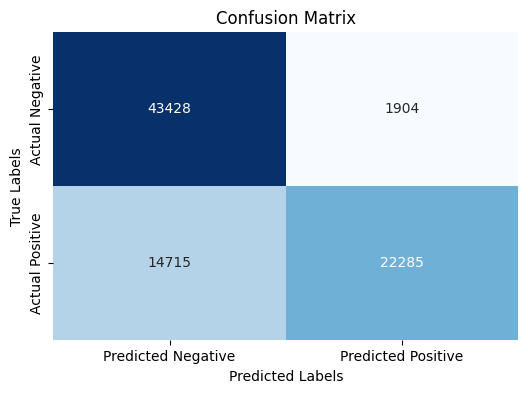

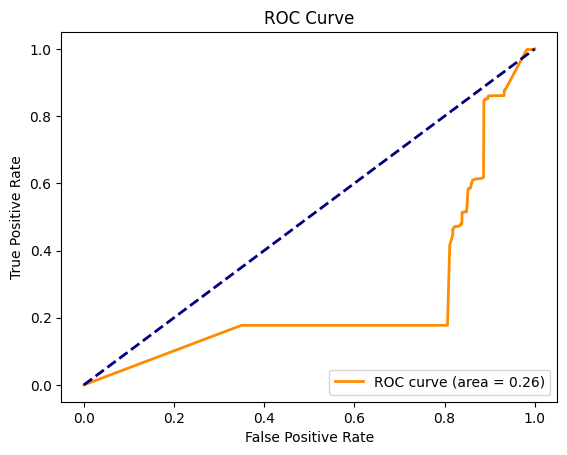

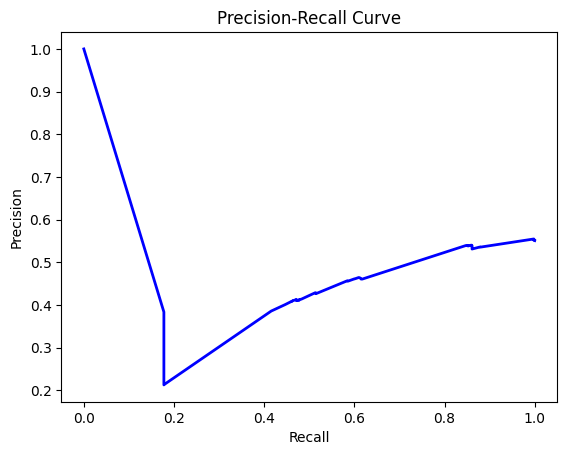

In [71]:
show_metrics(my_DTC)

Accuracy: 82.18676 %
Precision: 96.80610 %
Recall: 62.42162 %
F-score: 75.90128 %



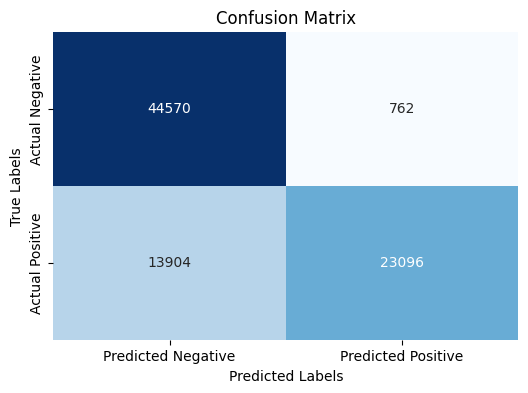

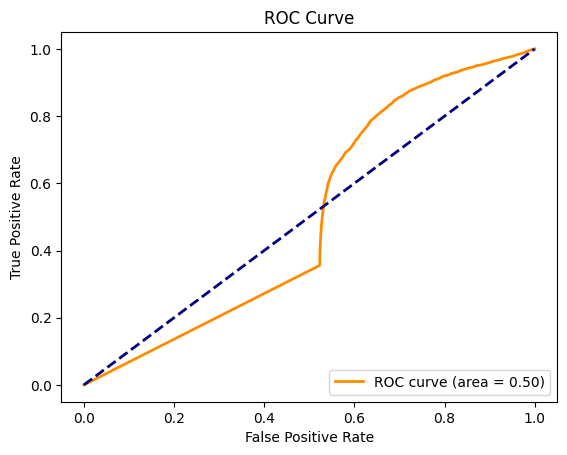

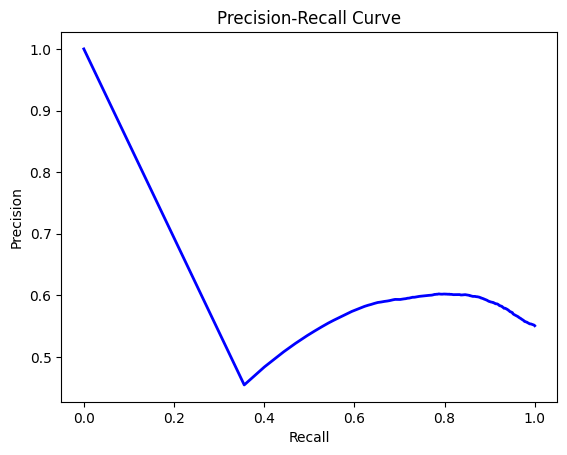

In [75]:
show_metrics(my_KNN)

## Conclusion


<ipython-input-88-b3a3936fa8f9>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=30, ha='right')


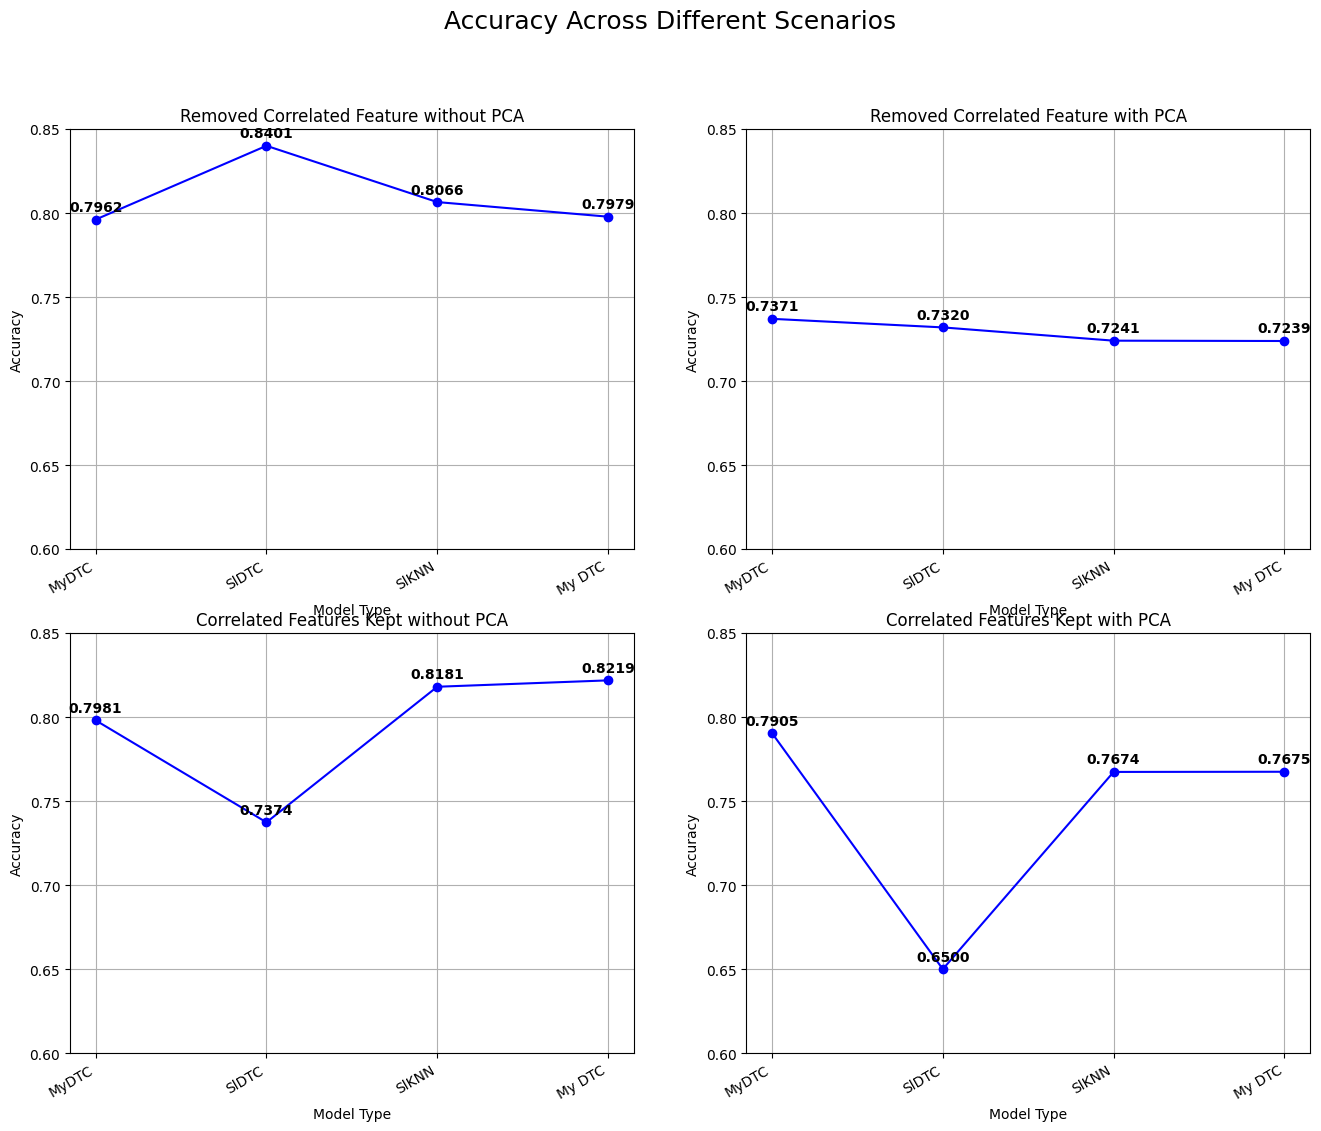

In [88]:
# Data
scenarios = ['Removed w/o PCA', 'Removed w/ PCA', 'Kept w/o PCA', 'Kept w/ PCA']

# Accuracies for each scenario
removed_no_pca = [0.7962, 0.8401, 0.8066, 0.7979]
removed_pca = [0.7371, 0.7320, 0.7241, 0.7239]
kept_no_pca = [0.7981, 0.7374, 0.8181, 0.8219]
kept_pca = [0.7905, 0.6500, 0.7674, 0.7675]

# X-axis labels
x_labels = ['MyDTC', 'SlDTC', 'SlKNN', 'My DTC']

data = [removed_no_pca, removed_pca, kept_no_pca, kept_pca]

fig, axs = plt.subplots(2, 2, figsize=(16, 12))  # Increase figure size for more space
fig.suptitle('Accuracy Across Different Scenarios', fontsize=18)

titles = ['Removed Correlated Feature without PCA',
          'Removed Correlated Feature with PCA',
          'Correlated Features Kept without PCA',
          'Correlated Features Kept with PCA']

for i, ax in enumerate(axs.flat):
    ax.plot(x_labels, data[i], marker='o', color='b')  # Use custom x_labels for x-axis
    ax.set_title(titles[i])
    ax.set_xlabel('Model Type')
    ax.set_ylabel('Accuracy')
    ax.set_ylim([0.6, 0.85])  # Adjust the limits for y-axis for better comparison
    ax.grid(True)

    ax.set_xticklabels(x_labels, rotation=30, ha='right')

    for j, v in enumerate(data[i]):
        ax.text(j, v + 0.005, f"{v:.4f}", ha='center', fontweight='bold')

plt.show()


In the above graphics we see that when we removed the highly correlated feature Scikit Learn were able to have better prediction meaning than for less features it were able to predict faster and more efficiently. However, globaly  the mean accuracy of all scenario is better for my model than for Scikit's. Mine (78% accuracy), Scikit (76%). We could chose to remove higly correlated feature and keep the scikit model for comparison but overall mine are sliigthly better and because, well, i did myself. Mainly because it was easy to compute other metrics


We then decided that the KNN model was the best because it has better precision and Fscore as well. More details on the report!